mask TC rainfall data using different regions in a shapefile 
calculate the area sum and area maximum of prec_fp and prec_fp_6h for 17 subregions of Australia. 

In [1]:
import glob
import math
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray  

In [2]:
def prec_max_sum(gdf, da_6h, da_total):
    '''
    gdf: shapefile dataframe
    da_6h: 6 hr precipitation data array
    da_total: total precipitation data array
    '''
    prec_6h = np.zeros((n_region,2))
    prec_total = np.zeros((n_region,2))
    
    for idx, region in gdf.iterrows():
        # Clip the NetCDF data using the region geometry
        masked_6h = da_6h.rio.clip([region.geometry], gdf.crs, drop=True)
        masked_total = da_total.rio.clip([region.geometry], gdf.crs, drop=True)

        prec_6h[idx,0] = masked_6h.sum()    
        prec_total[idx,0] = masked_total.sum()  

        max_6h = masked_6h.max() 
        max_total = masked_total.max()
         
        if math.isnan(max_6h):
            prec_6h[idx,1] = 0
        else:
            prec_6h[idx,1] = max_6h 
 
        if math.isnan(max_total):
            prec_total[idx,1] = 0
        else:
            prec_total[idx,1] = max_total 

    return np.concatenate((prec_6h, prec_total), axis=1)


In [3]:
# Load the shapefile with multiple regions
flnm_shp = "/glade/work/done/iag/t05/shapefile_data/IAG_DrainageDivisions_simplified.shp"  # Update with your shapefile path
gdf = gpd.read_file(flnm_shp)
n_region = len(gdf)

region_name = ['region']*n_region
 
for idx, region in gdf.iterrows():
    region_name[idx] = region["division"]   

In [ ]:
dir_i = '/glade/work/done/iag/t05/output_data/'
dir_o = '/glade/derecho/scratch/mingge/IAG/'

# Get a list of all .nc files in the directory
nc_files = glob.glob(dir_i + "*.nc")

nf = len(nc_files)
is_first = True
for flnm_i in nc_files:
    print(flnm_i)
    flnm_0 = flnm_i.split("/")[-1][:-3]
     
    ds = xr.open_dataset(flnm_i, decode_times=False)

    # Select the variable to be masked  
    da_6h = ds.prec_fp_6h[0].max(dim='track_pt_all')
    da_total = ds.prec_fp[0] 
  
    # Ensure the data has a CRS
    if "crs" not in da_6h.attrs:
        da_6h.rio.write_crs("EPSG:4326", inplace=True)  # Adjust CRS if needed

    if "crs" not in da_total.attrs:
        da_total.rio.write_crs("EPSG:4326", inplace=True)  # Adjust CRS if needed

    if is_first :
        # Reproject shapefile to match NetCDF CRS
        gdf = gdf.to_crs(da_total.rio.crs)
        is_first = False

    prec_2d = prec_max_sum(gdf, da_6h, da_total)
    
    # Convert the numpy array to a pandas DataFrame
    df = pd.DataFrame(prec_2d, columns=["6H sum", "6h max", "total sum", "total max"]).round(2)
    df.index = region_name 
    flnm_o = dir_o + flnm_0 + '.csv'
    print(flnm_o)
    df.to_csv(flnm_o)
     

#### Mask the NetCDF Data by Each Region

0 South Western Plateau


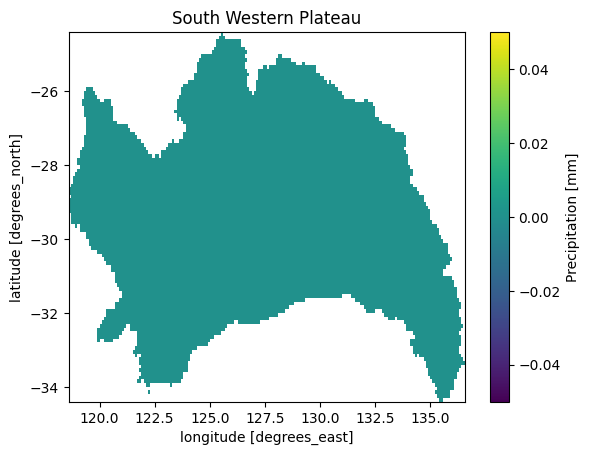

1 South West Coast


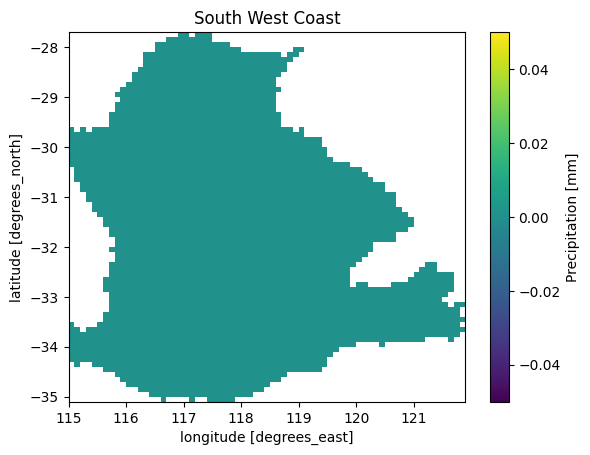

2 Tasmania


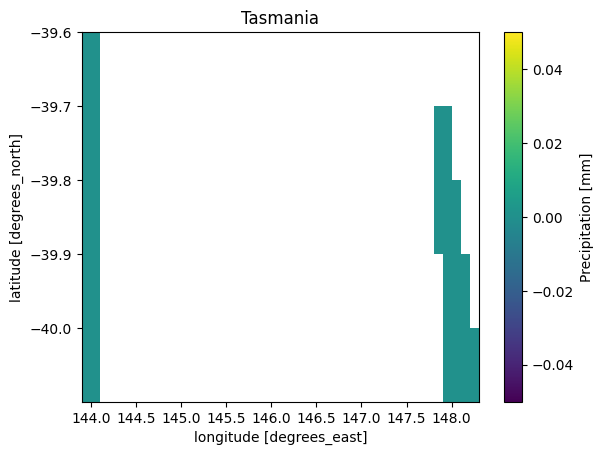

3 South East Coast (VICTORIA)


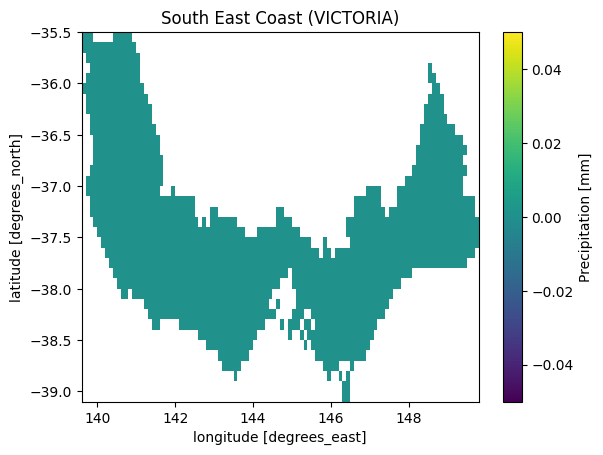

4 South Australian Gulf


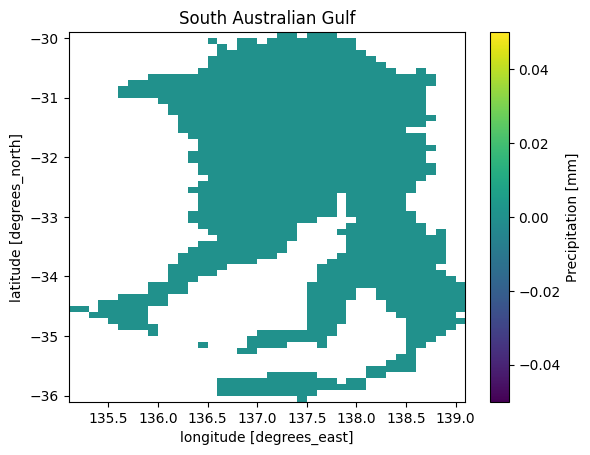

5 Murray-Darling Basin


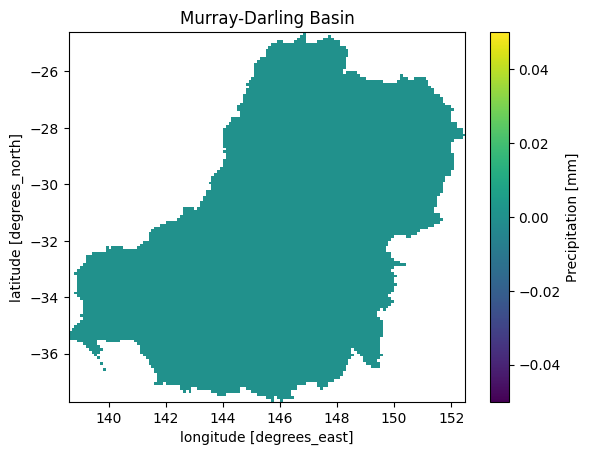

6 Pilbara-Gascoyne


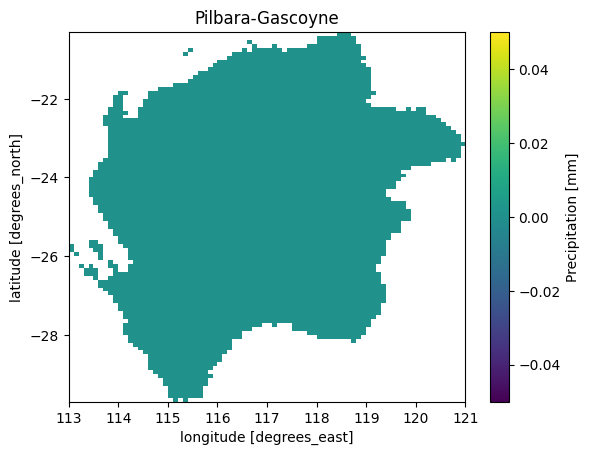

7 North Western Plateau


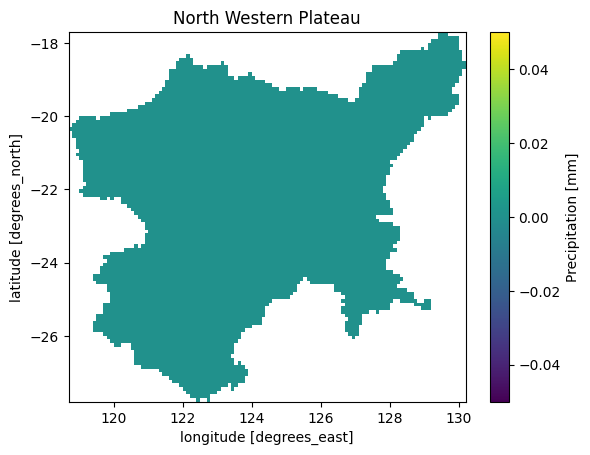

8 Carpentaria Coast


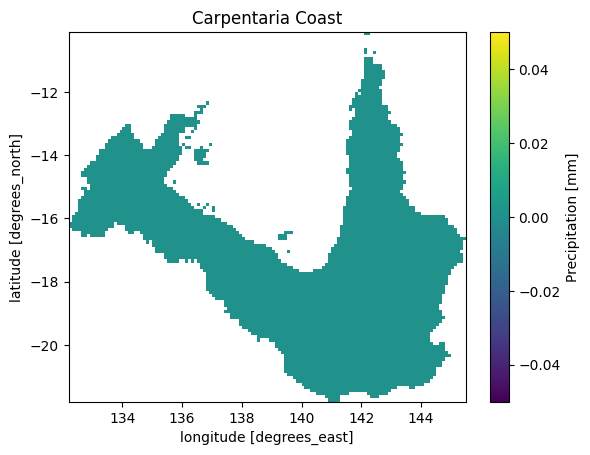

9 Lake Eyre Basin


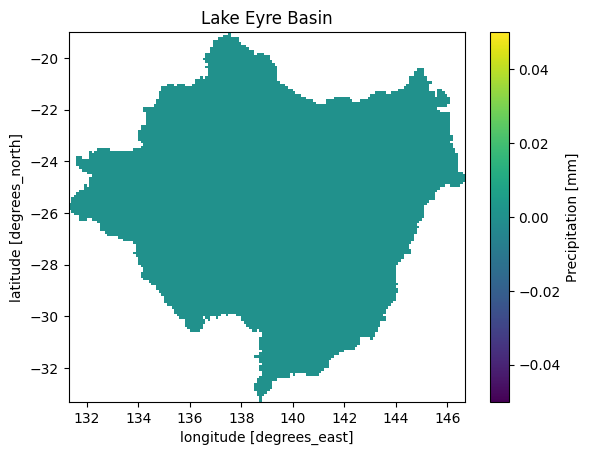

10 North Coast Queensland


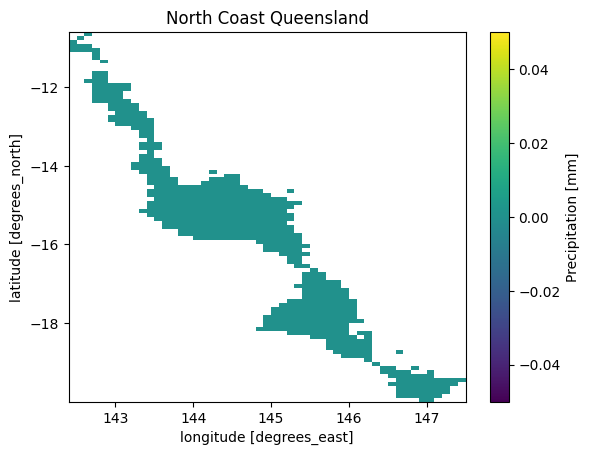

11 Burdekin & Fitzroy River


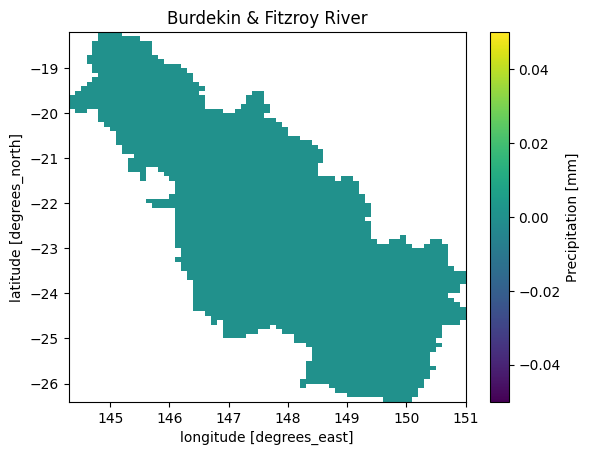

12 South East Queensland


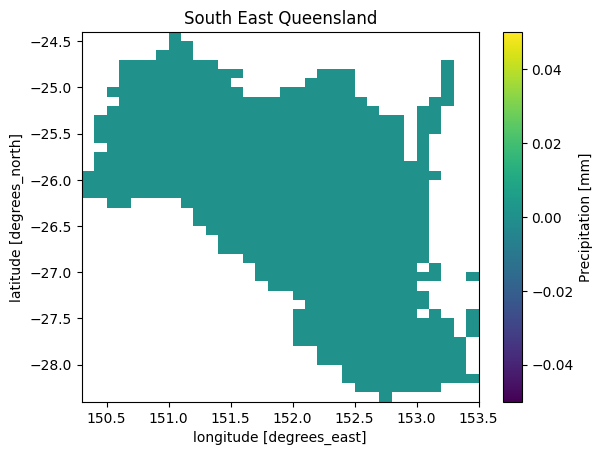

13 Mid Coast Queensland


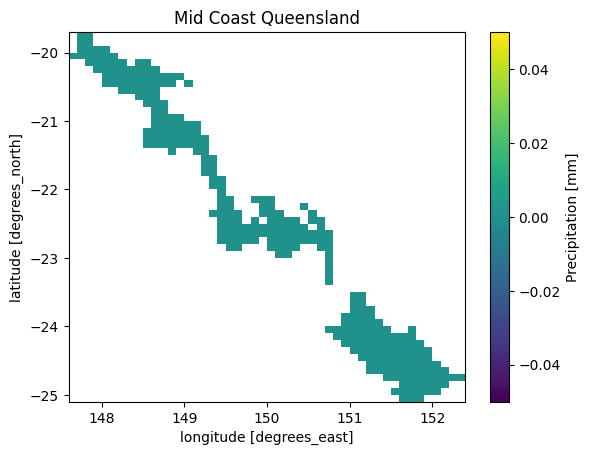

14 North Coast, NSW


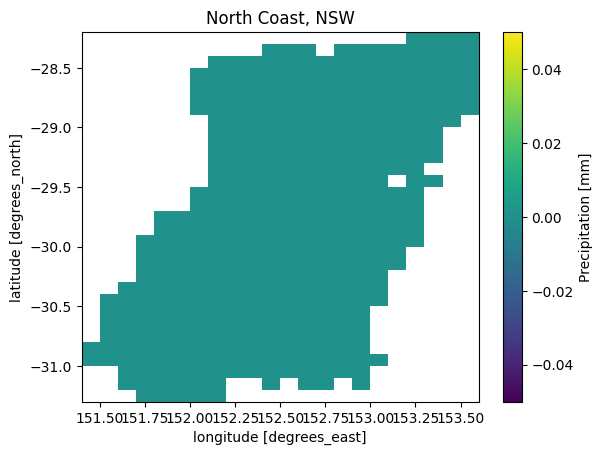

15 South Coast, NSW


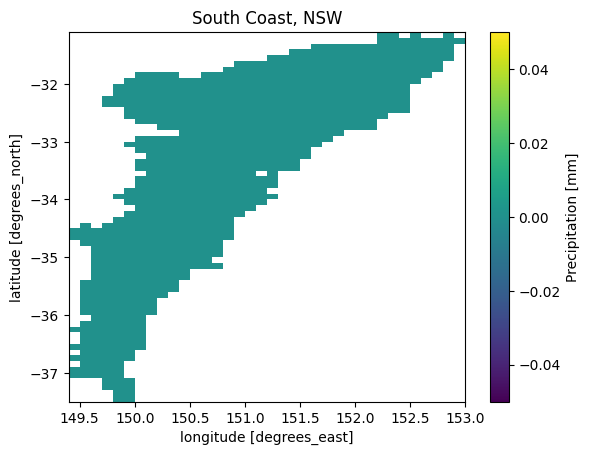

16 Tanami-Timor Sea Coast


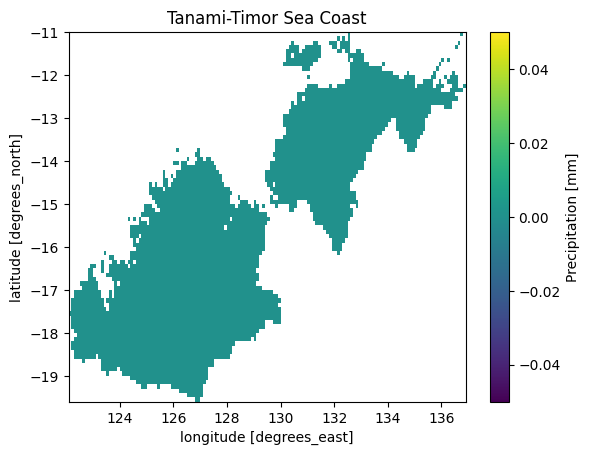

In [6]:
for idx, region in gdf.iterrows():
    print(idx, region["division"])
    # Clip the NetCDF data using the region geometry
    masked_total = da_total.rio.clip([region.geometry], gdf.crs, drop=True)
    
    # Optional: Plot the masked data for each region
    masked_total.plot()
    plt.title(region["division"])
    plt.show()    

In [5]:
df

,6H sum,6h max,total sum,total max
South Western Plateau,0.0,0.0,0.0,0.0
South West Coast,0.0,0.0,0.0,0.0
Tasmania,0.0,0.0,0.0,0.0
South East Coast (VICTORIA),0.0,0.0,0.0,0.0
South Australian Gulf,0.0,0.0,0.0,0.0
Murray-Darling Basin,0.0,0.0,0.0,0.0
Pilbara-Gascoyne,0.0,0.0,0.0,0.0
North Western Plateau,0.0,0.0,0.0,0.0
Carpentaria Coast,0.0,0.0,0.0,0.0
Lake Eyre Basin,0.0,0.0,0.0,0.0
